# **Import Modules**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.utils.data as utils
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import numpy as np
import pandas as pd
import math
import time
from sklearn.preprocessing import MinMaxScaler

In [ ]:
print(torch.__version__)

2.0.1+cu118


# **Prepare Data**

In [72]:
def PrepareDataset(speed_matrix, BATCH_SIZE = 40, seq_len = 12, pred_len = 1, train_propotion = 0.8, valid_propotion = 0.1):
    """ Prepare training and testing datasets and dataloaders.

    Convert speed/volume/occupancy matrix to training and testing dataset.
    The vertical axis of speed_matrix is the time axis and the horizontal axis
    is the spatial axis.

    Args:
        speed_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """
    time_len = speed_matrix.shape[0]

    scaler = MinMaxScaler()
    speed_matrix = scaler.fit_transform(speed_matrix)
    #max_speed = speed_matrix.max().max()
    #speed_matrix =  speed_matrix / max_speed

    speed_sequences, speed_labels = [], []
    for i in range(time_len - seq_len - pred_len):
        speed_sequences.append(speed_matrix[i:i+seq_len])
        speed_labels.append(speed_matrix[i+seq_len:i+seq_len+pred_len])
    speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)

    # shuffle and split the dataset to training and testing datasets
    sample_size = speed_sequences.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.shuffle(index)

    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))

    train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
    valid_data, valid_label = speed_sequences[train_index:valid_index], speed_labels[train_index:valid_index]
    test_data, test_label = speed_sequences[valid_index:], speed_labels[valid_index:]

    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)

    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)

    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)

    return train_dataloader, valid_dataloader, test_dataloader, scaler

In [73]:
def preprocess_adjacent_matrix(adj_matrix, normalized_k=0.1):

    # Calculates the standard deviation as theta.
    # adj_matrix = adj_matrix.to_numpy()
    distances = adj_matrix[~np.isinf(adj_matrix)].flatten()
    std = distances.std()
    adj_mx = np.exp(-np.square(adj_matrix / std))

    # Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
    adj_mx[adj_mx < normalized_k] = 0
    return adj_mx

# **Build Models**

In [64]:
def TrainModel(model, train_dataloader, valid_dataloader, learning_rate = 1e-5, num_epochs = 300, patience = 10, min_delta = 0.00001):

    inputs, labels = next(iter(train_dataloader))
    [batch_size, step_size, fea_size] = inputs.size()
    input_dim = fea_size
    hidden_dim = fea_size
    output_dim = fea_size

    model.cuda()

    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.L1Loss()

    learning_rate = 1e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

    use_gpu = torch.cuda.is_available()

    interval = 100
    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []

    cur_time = time.time()
    pre_time = time.time()

    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0

    for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

        trained_number = 0

        valid_dataloader_iter = iter(valid_dataloader)

        losses_epoch_train = []
        losses_epoch_valid = []

        for data in train_dataloader:
            inputs, labels = data

            if inputs.shape[0] != batch_size:
                continue

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            model.zero_grad()

            outputs = model(inputs)

            loss_train = loss_MSE(outputs, torch.squeeze(labels))

            losses_train.append(loss_train.data)
            losses_epoch_train.append(loss_train.data)

            optimizer.zero_grad()

            loss_train.backward()

            optimizer.step()

            # validation
            try:
                inputs_val, labels_val = next(valid_dataloader_iter)
            except StopIteration:
                valid_dataloader_iter = iter(valid_dataloader)
                inputs_val, labels_val = next(valid_dataloader_iter)

            if use_gpu:
                inputs_val, labels_val = Variable(inputs_val.cuda()), Variable(labels_val.cuda())
            else:
                inputs_val, labels_val = Variable(inputs_val), Variable(labels_val)

            outputs_val= model(inputs_val)

            loss_valid = loss_MSE(outputs_val, torch.squeeze(labels_val))
            losses_valid.append(loss_valid.data)
            losses_epoch_valid.append(loss_valid.data)

            # output
            trained_number += 1

        avg_losses_epoch_train = sum(losses_epoch_train) / float(len(losses_epoch_train))
        avg_losses_epoch_valid = sum(losses_epoch_valid) / float(len(losses_epoch_valid))
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)

        # Early Stopping
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = 10000.0
            if avg_losses_epoch_valid < min_loss_epoch_valid:
                min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print('Early Stopped at Epoch:', epoch)
                    break

        # Print training parameters
        cur_time = time.time()
        print('Epoch: {}, train_loss: {}, valid_loss: {}, time: {}, best model: {}'.format( \
                    epoch, \
                    avg_losses_epoch_train.cpu().data.numpy().argmax(),\
                    avg_losses_epoch_valid.cpu().data.numpy().argmax(),\
                    np.around([cur_time - pre_time] , decimals=2),\
                    is_best_model) )
        pre_time = cur_time
    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]

In [65]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

class MAPELoss(torch.nn.Module):
    def __init__(self):
        super(MAPELoss,self).__init__()

    def forward(self,x,y):
        loss = torch.mean(torch.abs((x - y) / x))
        return loss

In [66]:
def TestModel(model, test_dataloader):

    inputs, labels = next(iter(test_dataloader))
    [batch_size, step_size, fea_size] = inputs.size()

    cur_time = time.time()
    pre_time = time.time()

    use_gpu = torch.cuda.is_available()

    loss_RMSE = RMSELoss()
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.MSELoss()

    tested_batch = 0

    losses_rmse = []
    losses_mse = []
    losses_mape = []
    losses_l1 = []
    y_pred = []
    y_true = []

    for data in test_dataloader:
        inputs, labels = data

        if inputs.shape[0] != batch_size:
            continue

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # rnn.loop()
        hidden = model.initHidden(batch_size)

        outputs = None
        outputs = model(inputs)

        y_pred.append(outputs)
        y_true.append(torch.squeeze(labels))

        loss_RMSE = RMSELoss()
        loss_MAPE = MAPELoss()
        loss_MSE = torch.nn.MSELoss()
        loss_L1 = torch.nn.L1Loss()

        loss_rmse = loss_RMSE(outputs, torch.squeeze(labels))
        loss_mape = loss_MAPE(outputs, torch.squeeze(labels))
        loss_mse = loss_MSE(outputs, torch.squeeze(labels))
        loss_l1 = loss_L1(outputs, torch.squeeze(labels))

        losses_rmse.append(loss_rmse.cpu().data.numpy())
        losses_mse.append(loss_mse.cpu().data.numpy())
        losses_mape.append(loss_mape.cpu().data.numpy())
        losses_l1.append(loss_l1.cpu().data.numpy())

        tested_batch += 1

        if tested_batch % 1000 == 0:
            cur_time = time.time()
            print('Tested #: {}, loss_l1: {}, loss_mse: {}, time: {}'.format( \
                  tested_batch * batch_size, \
                  np.around([loss_l1.data[0]], decimals=8), \
                  np.around([loss_mse.data[0]], decimals=8), \
                  np.around([cur_time - pre_time], decimals=8) ) )
            pre_time = cur_time
    losses_l1 = np.array(losses_l1)
    losses_mse = np.array(losses_mse)
    mean_mse = np.mean(losses_mse)

    losses_rmse = np.array(losses_rmse)
    mean_rmse = np.mean(losses_rmse)

    losses_mape = np.array(losses_mape)
    mean_mape = np.mean(losses_mape)

    mean_l1 = np.mean(losses_l1)
    std_l1 = np.std(losses_l1)

    print('Tested: MAE: {}, MAPE : {}, MSE: {}, RMSE: {}'.format(mean_l1, mean_mape, mean_mse, mean_rmse))
    return y_pred, y_true, [losses_l1, losses_mse, mean_l1, std_l1]

In [67]:
class LSTM(nn.Module):
    def __init__(self, input_size, cell_size, hidden_size, output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        """
        super(LSTM, self).__init__()

        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)

        self.output_last = output_last

    def step(self, input, Hidden_State, Cell_State):
        combined = torch.cat((input, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)

        return Hidden_State, Cell_State

    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)

        if self.output_last:
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)
            return Hidden_State
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs

    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State

In [68]:
class ConvLSTM(nn.Module):
    def __init__(self, input_size, cell_size, hidden_size, output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        """
        super(ConvLSTM, self).__init__()

        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)

        self.conv = nn.Conv1d(1, hidden_size, hidden_size)

        self.output_last = output_last

    def step(self, input, Hidden_State, Cell_State):

        conv = self.conv(input)

        combined = torch.cat((conv, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)

        return Hidden_State, Cell_State

    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)

        if self.output_last:
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)
            return Hidden_State
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs

    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State

In [69]:
class LocalizedSpectralGraphConvolution(nn.Module):
    def __init__(self, A, K):

        super(LocalizedSpectralGraphConvolution, self).__init__()


        self.K = K
        self.A = A.cuda()
        feature_size = A.shape[0]
        self.D = torch.diag(torch.sum(self.A, dim=0)).cuda()

        I = torch.eye(feature_size,feature_size).cuda()
        self.L = I - torch.inverse(torch.sqrt(self.D)).matmul(self.A).matmul(torch.inverse(torch.sqrt(self.D)))

        L_temp = I
        for i in range(K):
            L_temp = torch.matmul(L_temp, self.L)
            if i == 0:
                self.L_tensor = torch.unsqueeze(L_temp, 2)
            else:
                self.L_tensor = torch.cat((self.L_tensor, torch.unsqueeze(L_temp, 2)), 2)

        self.L_tensor = Variable(self.L_tensor.cuda(), requires_grad=False)

        self.params = Parameter(torch.FloatTensor(K).cuda())

        stdv = 1. / math.sqrt(K)
        for i in range(K):
            self.params[i].data.uniform_(-stdv, stdv)

    def forward(self, input):
        x = input

        conv = x.matmul( torch.sum(self.params.expand_as(self.L_tensor) * self.L_tensor, 2) )

        return conv


class LocalizedSpectralGraphConvolutionalLSTM(nn.Module):

    def __init__(self, K, A, feature_size, Clamp_A=True, output_last = True):
        '''
        Args:
            K: K-hop graph
            A: adjacency matrix
            FFR: free-flow reachability matrix
            feature_size: the dimension of features
            Clamp_A: Boolean value, clamping all elements of A between 0. to 1.
        '''
        super(LocalizedSpectralGraphConvolutionalLSTM, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = feature_size

        self.K = K
        self.A = A
        self.gconv = LocalizedSpectralGraphConvolution(A, K)

        hidden_size = self.feature_size
        input_size = self.feature_size + hidden_size

        self.fl = nn.Linear(input_size, hidden_size)
        self.il = nn.Linear(input_size, hidden_size)
        self.ol = nn.Linear(input_size, hidden_size)
        self.Cl = nn.Linear(input_size, hidden_size)

        self.output_last = output_last

    def step(self, input, Hidden_State, Cell_State):

#         conv_sample_start = time.time()
        conv = F.relu(self.gconv(input))
#         conv_sample_end = time.time()
#         print('conv_sample:', (conv_sample_end - conv_sample_start))
        combined = torch.cat((conv, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)

        return Hidden_State, Cell_State

    def Bi_torch(self, a):
        a[a < 0] = 0
        a[a > 0] = 1
        return a

    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)

        outputs = None

        for i in range(time_step):
            Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)

            if outputs is None:
                outputs = Hidden_State.unsqueeze(1)
            else:
                outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
#         print(type(outputs))

        if self.output_last:
            return outputs[:,-1,:]
        else:
            return outputs

    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State
    def reinitHidden(self, batch_size, Hidden_State_data, Cell_State_data):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(Hidden_State_data.cuda(), requires_grad=True)
            Cell_State = Variable(Cell_State_data.cuda(), requires_grad=True)
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(Hidden_State_data, requires_grad=True)
            Cell_State = Variable(Cell_State_data, requires_grad=True)
            return Hidden_State, Cell_State

# **Main**

In [74]:
if __name__ == "__main__":
  speed_matrix = pd.read_csv('/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/Traffic/traffic.csv').set_index('datetime').to_numpy()
  A = pd.read_csv('/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/adj_matrix.csv').to_numpy()
  A = preprocess_adjacent_matrix(A, normalized_k=0.1)
  train_dataloader, valid_dataloader, test_dataloader, scaler = PrepareDataset(speed_matrix)
  inputs, labels = next(iter(train_dataloader))
  [batch_size, step_size, fea_size] = inputs.size()
  input_dim = fea_size
  hidden_dim = fea_size
  output_dim = fea_size

**LSTM**

In [75]:
lstm = LSTM(input_dim, hidden_dim, output_dim, output_last = True)
lstm, lstm_loss = TrainModel(lstm, train_dataloader, valid_dataloader, num_epochs = 10)
y_pred, y_true, lstm_test = TestModel(lstm, test_dataloader )

Epoch: 0, train_loss: 0, valid_loss: 0, time: [7.91], best model: 1
Epoch: 1, train_loss: 0, valid_loss: 0, time: [8.83], best model: 1
Epoch: 2, train_loss: 0, valid_loss: 0, time: [8.86], best model: 1
Epoch: 3, train_loss: 0, valid_loss: 0, time: [7.9], best model: 1
Epoch: 4, train_loss: 0, valid_loss: 0, time: [8.97], best model: 1
Epoch: 5, train_loss: 0, valid_loss: 0, time: [8.68], best model: 1
Epoch: 6, train_loss: 0, valid_loss: 0, time: [8.19], best model: 1
Epoch: 7, train_loss: 0, valid_loss: 0, time: [9.06], best model: 1
Epoch: 8, train_loss: 0, valid_loss: 0, time: [8.25], best model: 1
Epoch: 9, train_loss: 0, valid_loss: 0, time: [8.5], best model: 1
Tested: MAE: 0.10175803303718567, MAPE : 0.6947609782218933, MSE: 0.020240604877471924, RMSE: 0.1416483074426651


**LSGC-LSTM**

In [ ]:
K = 16
Clamp_A = False
lsgclstm = LocalizedSpectralGraphConvolutionalLSTM(K, torch.Tensor(A), A.shape[0], Clamp_A=Clamp_A, output_last = True)
lsgclstm, lsgclstm_loss = TrainModel(lsgclstm, train_dataloader, valid_dataloader, num_epochs = 10)
y_pred2, y_true2, lsgclstm_test = TestModel(lsgclstm, test_dataloader)

Epoch: 0, train_loss: 0, valid_loss: 0, time: [11.26], best model: 1
Epoch: 1, train_loss: 0, valid_loss: 0, time: [11.25], best model: 1
Epoch: 2, train_loss: 0, valid_loss: 0, time: [11.9], best model: 1
Epoch: 3, train_loss: 0, valid_loss: 0, time: [11.09], best model: 1
Epoch: 4, train_loss: 0, valid_loss: 0, time: [11.06], best model: 1
Epoch: 5, train_loss: 0, valid_loss: 0, time: [10.23], best model: 1
Epoch: 6, train_loss: 0, valid_loss: 0, time: [11.2], best model: 1
Epoch: 7, train_loss: 0, valid_loss: 0, time: [11.46], best model: 1
Epoch: 8, train_loss: 0, valid_loss: 0, time: [11.44], best model: 1
Epoch: 9, train_loss: 0, valid_loss: 0, time: [11.41], best model: 1
Tested: MAE: 0.1998506486415863, MAPE : 0.5403767228126526, MSE: 0.05508984997868538, RMSE: 0.23439638316631317


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.
    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2021-1-1 00:00'
    x = pd.date_range(d, periods=288, freq='5min')

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    plt.show()

In [ ]:
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i].detach().to('cpu').numpy()
for i in range(len(y_true)):
  y_true[i] = y_true[i].detach().to('cpu').numpy()

In [ ]:
y_pred

[array([[0.09134126, 0.09003854, 0.10410663, ..., 0.02238687, 0.09598234,
         0.10108408],
        [0.23165473, 0.23445119, 0.3047243 , ..., 0.03825607, 0.32837835,
         0.34381753],
        [0.01650224, 0.02312475, 0.01973481, ..., 0.0026201 , 0.00703314,
         0.01478935],
        ...,
        [0.12311121, 0.11851703, 0.12623082, ..., 0.02480163, 0.11237247,
         0.10705806],
        [0.12254218, 0.1187989 , 0.15185541, ..., 0.02674455, 0.16128448,
         0.15767522],
        [0.05066432, 0.05501149, 0.05625667, ..., 0.01093211, 0.05523523,
         0.05850203]], dtype=float32),
 array([[0.1882606 , 0.18777011, 0.21864954, ..., 0.02890361, 0.24853753,
         0.2590905 ],
        [0.04833148, 0.05246941, 0.04930696, ..., 0.00980971, 0.03995698,
         0.04467258],
        [0.05758419, 0.05994709, 0.06302254, ..., 0.01032342, 0.05486641,
         0.05964032],
        ...,
        [0.2586959 , 0.25681335, 0.36109346, ..., 0.04709643, 0.3613448 ,
         0.35932642

In [ ]:
np.array(y_pred).reshape(-1,)

array([0.09134126, 0.09003854, 0.10410663, ..., 0.00224576, 0.00500283,
       0.01336795], dtype=float32)

In [ ]:
np.array(y_pred).shape

(525, 40, 33)

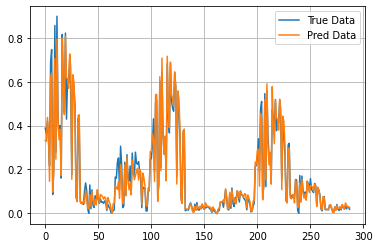

In [ ]:
fig = plt.figure()
d = '2021-12-1 00:00'
x = pd.date_range(d, periods=288, freq='5min')
plt.plot(x,np.array(y_true).reshape(-1,)[:288], label='True Data')
plt.plot(y,np.array(y_pred).reshape(-1,)[:288], label='Pred Data')
plt.legend()
plt.grid(True)
plt.show()